# Hidden Markov Model for NER


In [1]:
from app.travel_resolver.libs.nlp.data_processing import from_bio_file_to_examples

BIO_FILE = "data/bio/fr.bio/1k_samples.bio"

sentences, labels, vocab, unique_labels = from_bio_file_to_examples(
    BIO_FILE, process_sentence=True
)

[nltk_data] Downloading package punkt_tab to /Users/az-r-
[nltk_data]     ow/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
def t2_given_t1(
    t2: str | int,
    t1: str | int,
    train_bag=labels,
    unique_labels_mapping: dict = unique_labels,
):
    """
    Get the probability of getting t2 given t1 in the given labels

    Args:
      t2: str | int, the second tag
      t1: str | int, the first tag
      train_bag: list, the list of labels

    Returns:
      float, the probability of getting t2 given t1
    """
    t1 = t1 if isinstance(t1, int) else unique_labels_mapping[t1]
    t2 = t2 if isinstance(t2, int) else unique_labels_mapping[t2]
    count_t1 = 0
    count_t2_t1 = 0
    for row in train_bag:
        for index in range(len(row) - 1):
            if row[index] == t1:
                count_t1 += 1
            if row[index] == t1 and row[index + 1] == t2:
                count_t2_t1 += 1
    return count_t2_t1 / count_t1

In the next part, we will be getting the **transition matrix** which represents the _probability_ of transitioning from a state to another $P(S_2 | S_1)$. In our case it would be for example $P(O | \text{ARR-LOC})$.


In [17]:
import numpy as np

tags = list(unique_labels.keys())
n_tags = len(tags)

trans_matrix = np.zeros((n_tags, n_tags))

for t1 in range(n_tags):
    for t2 in range(n_tags):
        trans_matrix[t1][t2] = t2_given_t1(tags[t1], tags[t2])

trans_matrix

array([[0.81054505, 0.93784787, 0.93186004],
       [0.09468065, 0.06215213, 0.        ],
       [0.0947743 , 0.        , 0.06813996]])

In [19]:
import pandas as pd

trans_matrix_df = pd.DataFrame(trans_matrix, columns=tags, index=tags)

trans_matrix_df

,O,LOC-ARR,LOC-DEP
O,0.810545,0.937848,0.93186
LOC-ARR,0.094681,0.062152,0.00000
LOC-DEP,0.094774,0.000000,0.06814


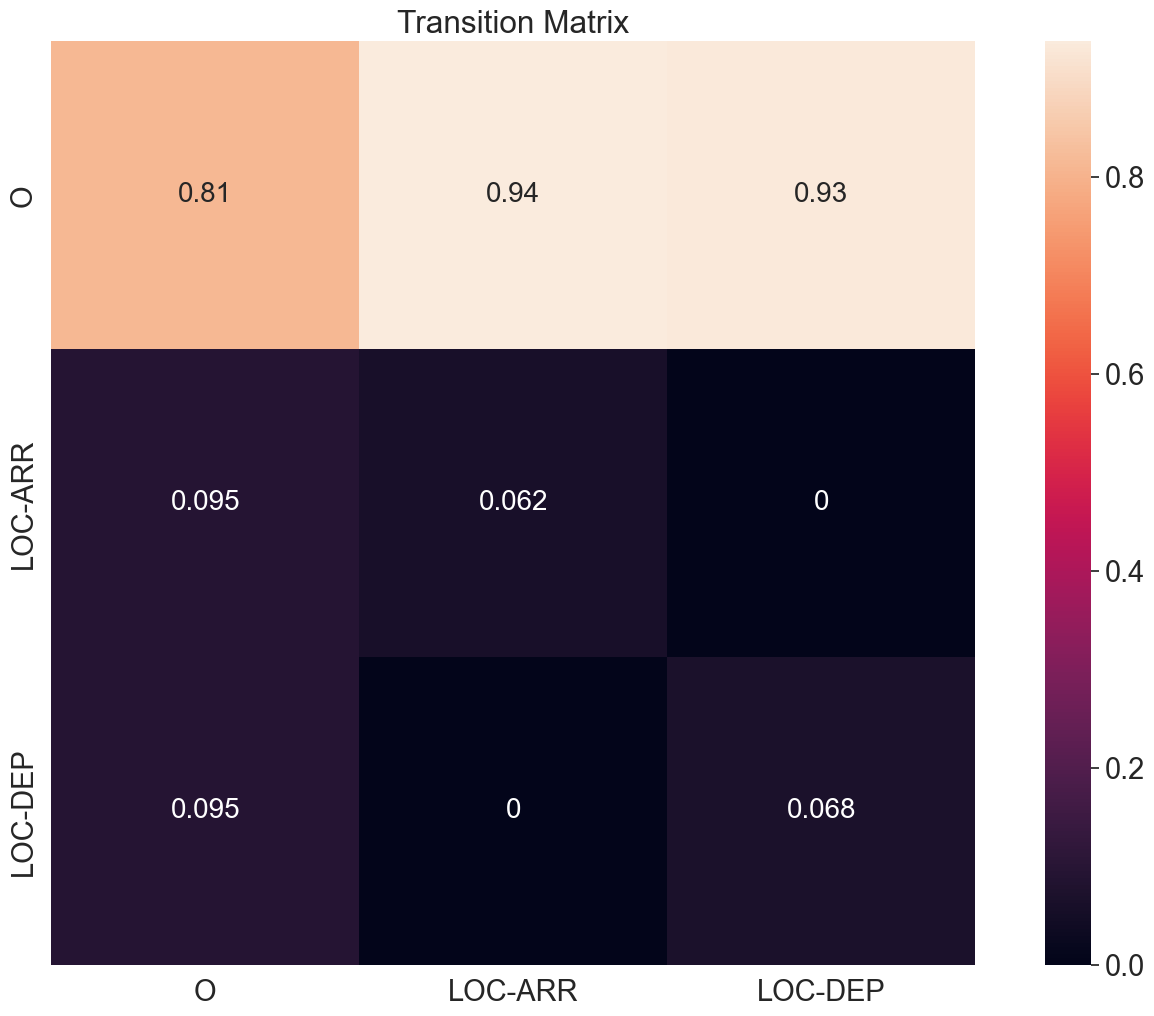

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))

sns.set(font_scale=1.9)

sns.heatmap(trans_matrix_df, annot=True, square=True, annot_kws={"fontsize": 20})

plt.title("Transition Matrix")

plt.show()

In [48]:
def get_emission_prob(sentences=sentences, labels=labels, unique_labels=unique_labels):
    tags = list(unique_labels.keys())
    word_label_count = {}
    sample_count = {tag: 0 for tag in tags}
    for i in range(len(sentences)):
        for word, label in zip(sentences[i].split(" "), labels[i]):
            if word not in word_label_count:
                word_label_count[word] = sample_count.copy()
            else:
                word_label_count[word][tags[label]] += 1
    return word_label_count